# Load Libraries

In [1]:
# dl packages
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Load data

In [3]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# # get all words length in comment
train_data = pd.read_csv('training.csv')
train_data.rename(columns={'text': 'Comment'}, inplace=True)

train_data['Emotion'] = train_data['label'].map(emotion_map)
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data = train_data.drop("label",axis=1)

test_data = pd.read_csv('test.csv')
test_data.rename(columns={'text': 'Comment'}, inplace=True)
test_data['Emotion'] = test_data['label'].map(emotion_map)
test_data['length'] = [len(x) for x in test_data['Comment']]
test_data = test_data.drop("label",axis=1)

validation_data = pd.read_csv('validation.csv')
validation_data.rename(columns={'text': 'Comment'}, inplace=True)
validation_data['Emotion'] = validation_data['label'].map(emotion_map)
validation_data['length'] = [len(x) for x in validation_data['Comment']]
validation_data = validation_data.drop("label",axis=1)

train_data = pd.concat([train_data, validation_data], ignore_index=True)
print(train_data)

                                                 Comment  Emotion  length
0                                i didnt feel humiliated  sadness      23
1      i can go from feeling so hopeless to so damned...  sadness     108
2       im grabbing a minute to post i feel greedy wrong    anger      48
3      i am ever feeling nostalgic about the fireplac...     love      92
4                                   i am feeling grouchy    anger      20
...                                                  ...      ...     ...
17995  im having ssa examination tomorrow in the morn...  sadness     191
17996  i constantly worry about their fight against n...      joy     173
17997  i feel its important to share this info for th...      joy      80
17998  i truly feel that if you are passionate enough...      joy     105
17999  i feel like i just wanna buy any cute make up ...      joy      74

[18000 rows x 3 columns]


In [4]:
print(train_data)
print(test_data)

                                                 Comment  Emotion  length
0                                i didnt feel humiliated  sadness      23
1      i can go from feeling so hopeless to so damned...  sadness     108
2       im grabbing a minute to post i feel greedy wrong    anger      48
3      i am ever feeling nostalgic about the fireplac...     love      92
4                                   i am feeling grouchy    anger      20
...                                                  ...      ...     ...
17995  im having ssa examination tomorrow in the morn...  sadness     191
17996  i constantly worry about their fight against n...      joy     173
17997  i feel its important to share this info for th...      joy      80
17998  i truly feel that if you are passionate enough...      joy     105
17999  i feel like i just wanna buy any cute make up ...      joy      74

[18000 rows x 3 columns]
                                                Comment  Emotion  length
0     im feel

In [5]:
train_data.shape

(18000, 3)

In [6]:
train_data.isnull().sum()
train_data[train_data.isna().any(axis=1)]

,Comment,Emotion,length


In [7]:
train_data.duplicated().sum()

1

# EDA

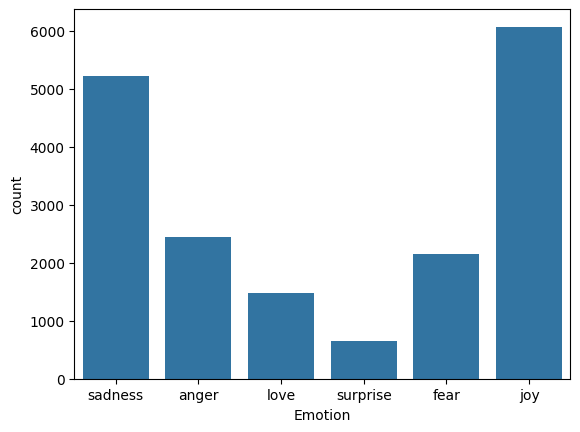

In [8]:
sns.countplot(x = train_data['Emotion'])
plt.show()

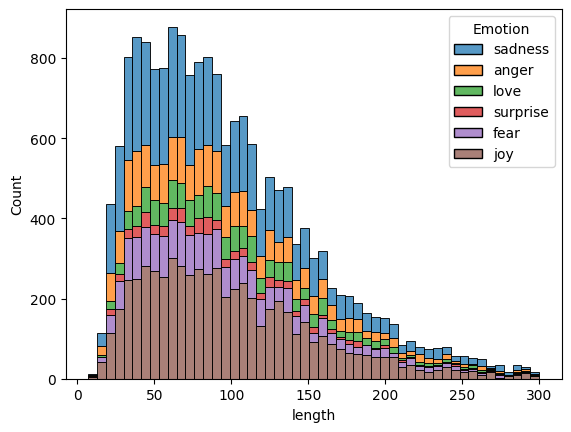

In [9]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

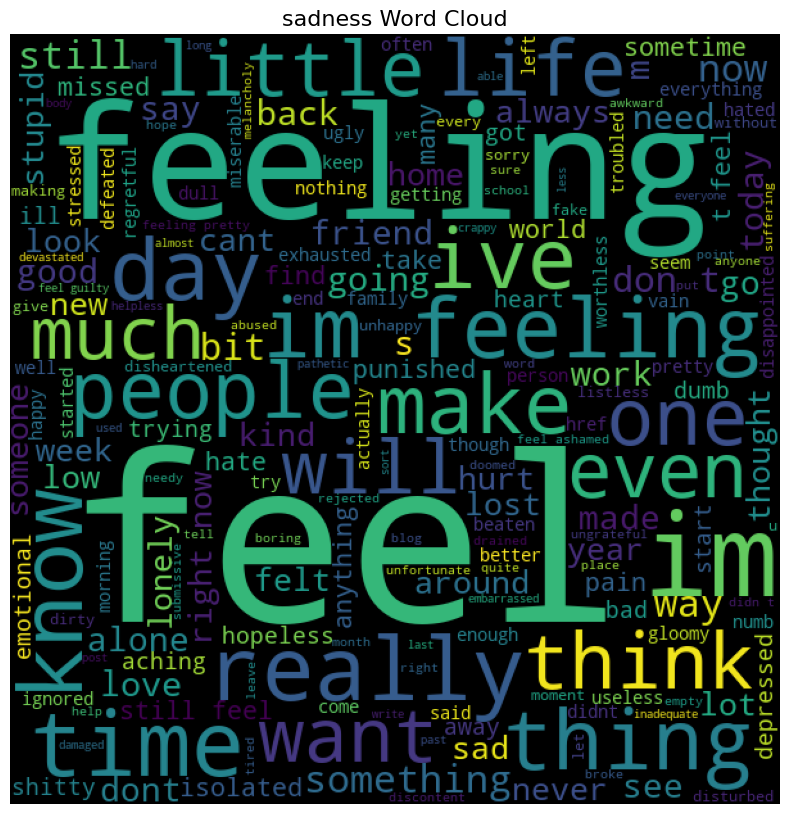

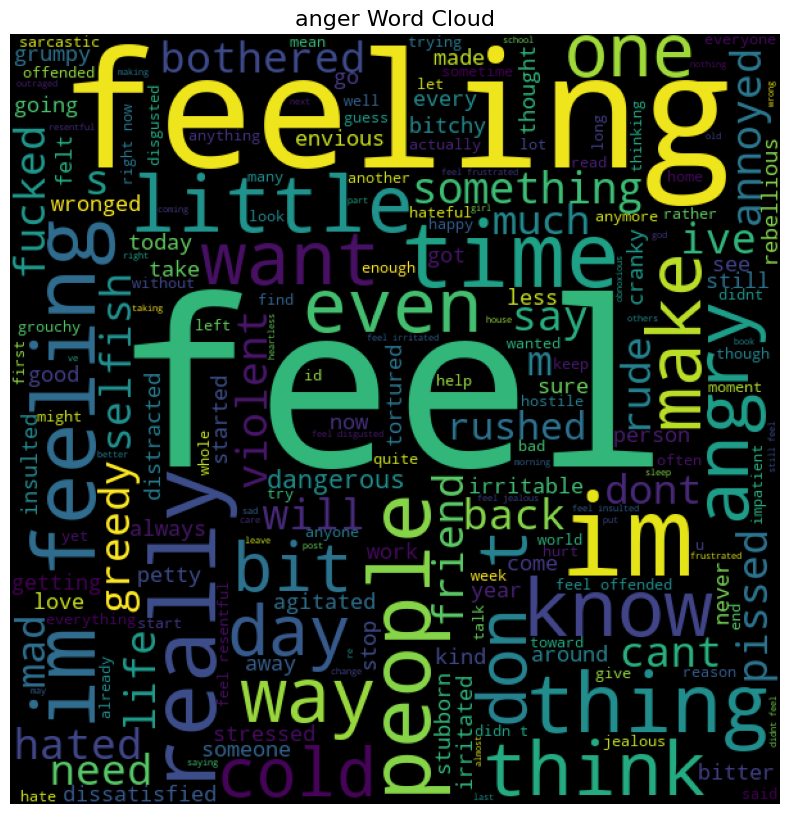

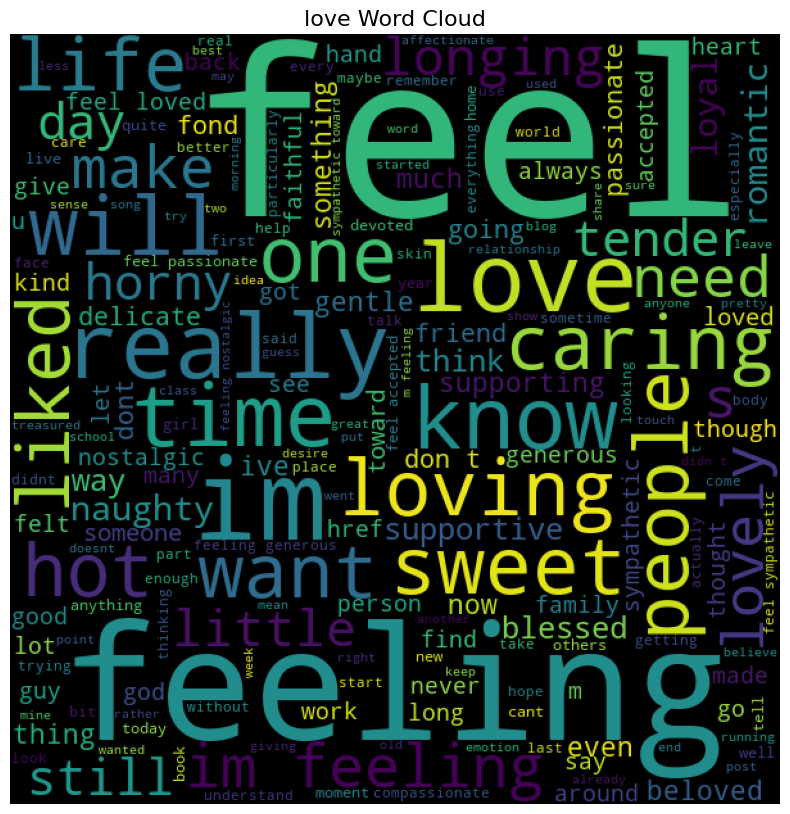

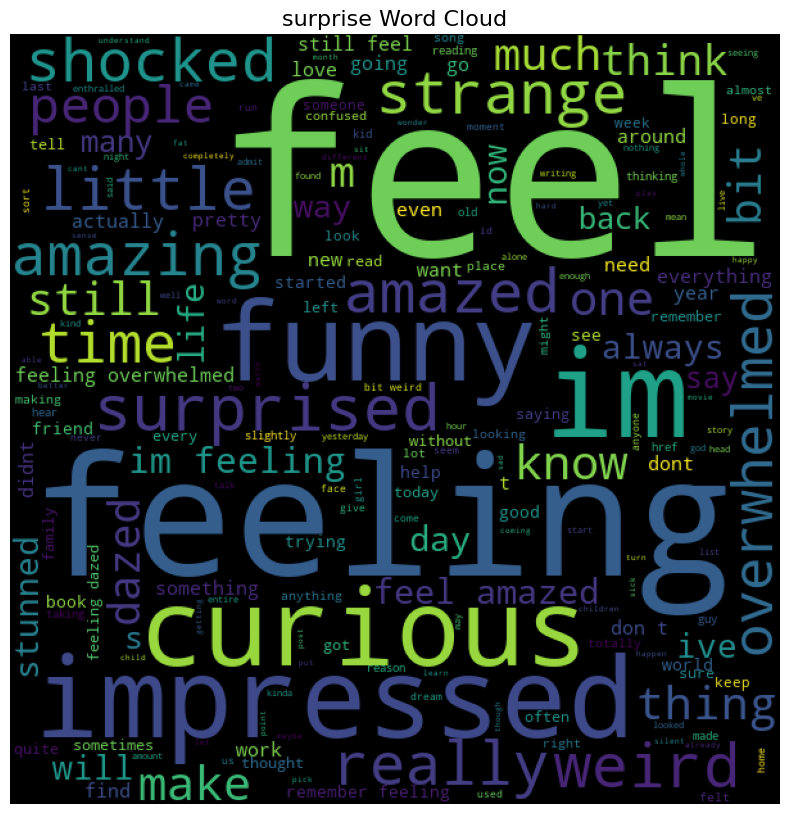

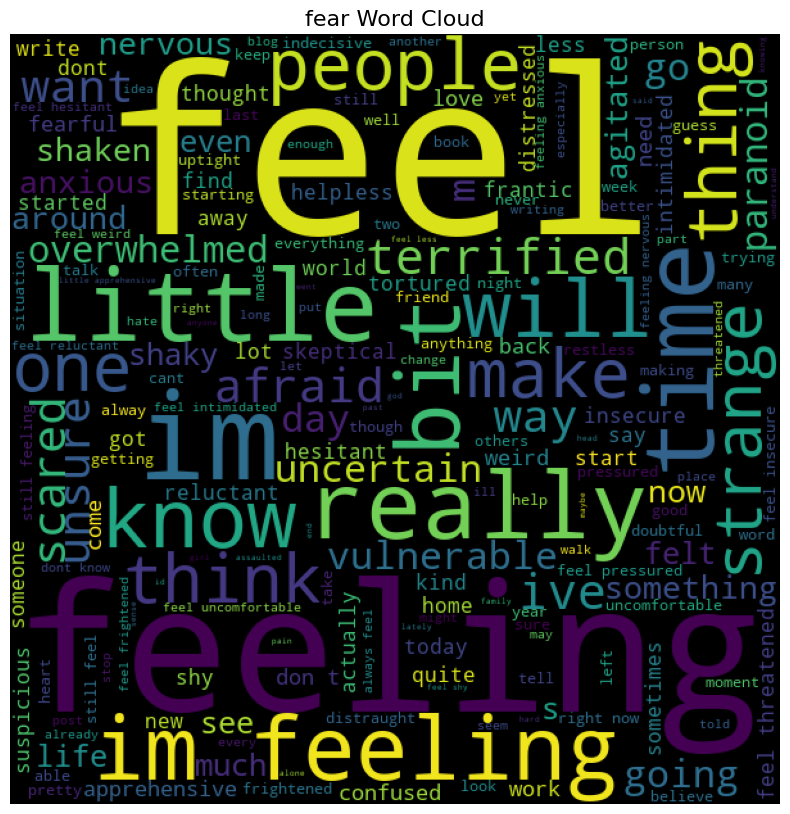

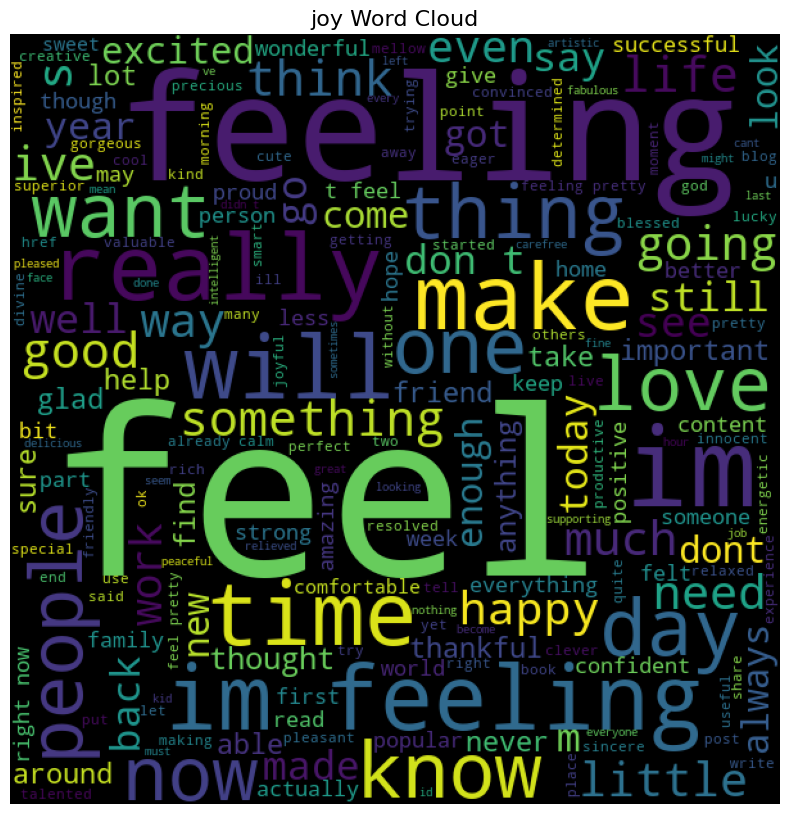

In [10]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

# Data Preprocessing
# Encode emotions

In [11]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])

In [12]:
print(train_data)
print(test_data)

                                                 Comment  Emotion  length
0                                i didnt feel humiliated        4      23
1      i can go from feeling so hopeless to so damned...        4     108
2       im grabbing a minute to post i feel greedy wrong        0      48
3      i am ever feeling nostalgic about the fireplac...        3      92
4                                   i am feeling grouchy        0      20
...                                                  ...      ...     ...
17995  im having ssa examination tomorrow in the morn...        4     191
17996  i constantly worry about their fight against n...        2     173
17997  i feel its important to share this info for th...        2      80
17998  i truly feel that if you are passionate enough...        2     105
17999  i feel like i just wanna buy any cute make up ...        2      74

[18000 rows x 3 columns]
                                                Comment  Emotion  length
0     im feel

# Applying Deep learning Using LSTM

# Text Cleaning, Ecoding, and Padding

In [14]:
# 下载NLTK的stopwords
nltk.download('stopwords')

# 获取英文停用词列表
stopwords = set(nltk.corpus.stopwords.words('english'))

# 移除影响情感分类的停用词
stopwords.discard("not")
stopwords.discard("no")
stopwords.discard("never")
stopwords.discard("very")
stopwords.discard("too")
stopwords.discard("so")
stopwords.discard("quite")
stopwords.discard("what")
stopwords.discard("why")
stopwords.discard("how")

def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
print(x_train)

[[    0     0     0 ...  6957  4738  6348]
 [    0     0     0 ...  6798  5513  1484]
 [    0     0     0 ...  4738  2698   772]
 ...
 [    0     0     0 ...  6599 10627   953]
 [    0     0     0 ...  1125  3459  7641]
 [    0     0     0 ...   230  5365  9240]]


# Model Building and Training

In [23]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping

# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
282/282 [==============================] - 61s 210ms/step - loss: 1.6092 - accuracy: 0.3383
Epoch 2/10
282/282 [==============================] - 60s 212ms/step - loss: 0.9588 - accuracy: 0.6677
Epoch 3/10
282/282 [==============================] - 60s 212ms/step - loss: 0.5398 - accuracy: 0.8278
Epoch 4/10
282/282 [==============================] - 61s 215ms/step - loss: 0.3691 - accuracy: 0.8796
Epoch 5/10
282/282 [==============================] - 60s 213ms/step - loss: 0.2640 - accuracy: 0.9129
Epoch 6/10
282/282 [==============================] - 60s 212ms/step - loss: 0.1888 - accuracy: 0.9386
Epoch 7/10
282/282 [==============================] - 59s 211ms/step - loss: 0.1453 - accuracy: 0.9520
Epoch 8/10
282/282 [==============================] - 60s 212ms/step - loss: 0.1228 - accuracy: 0.9596
Epoch 9/10
282/282 [==============================] - 60s 213ms/step - loss: 0.1072 - accuracy: 0.9636
Epoch 10/10
282/282 [==============================] - 61s 216ms/step - l

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,epoch
0,1.537345,0.383889,0
1,0.895116,0.696667,1
2,0.662603,0.797000,2
3,0.495818,0.846667,3
4,0.378860,0.881833,4
5,0.319813,0.896000,5
6,0.242878,0.924611,6
7,0.423938,0.872611,7
8,0.220554,0.933667,8
9,0.187693,0.942500,9


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

x_test = text_cleaning(test_data, "Comment", vocab_size=11000, max_len=300)
y_test = to_categorical(test_data["Emotion"])

# 評估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 進行預測
predictions = model.predict(x_test)

# 將概率轉換為類別標籤
predicted_classes = np.argmax(predictions, axis=1)

# 打印前幾個預測類別
print(predicted_classes[:5])

# 打印前幾個真實類別
true_classes = np.argmax(y_test, axis=1)
print(true_classes[:5])

# 計算並打印分類報告
print(classification_report(true_classes, predicted_classes))

# 計算並打印混淆矩陣
print(confusion_matrix(true_classes, predicted_classes))


63/63 [==============================] - 1s 12ms/step - loss: 0.5008 - accuracy: 0.8545
Test Loss: 0.5007924437522888
Test Accuracy: 0.8544999957084656
63/63 [==============================] - 1s 12ms/step
[4 4 4 2 4]
[4 4 4 2 4]
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       275
           1       0.78      0.87      0.82       224
           2       0.89      0.89      0.89       695
           3       0.62      0.73      0.67       159
           4       0.92      0.91      0.91       581
           5       0.65      0.50      0.56        66

    accuracy                           0.85      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.86      0.85      0.85      2000

[[218  14  18   4  20   1]
 [  5 195   3   0  12   9]
 [  4   7 620  50   6   8]
 [  1   2  32 116   8   0]
 [ 12  13  12  17 527   0]
 [  4  18   9   0   2  33]]


# Predictive System

In [32]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    print(corpus)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict
sentences = [
            "Rob was on cloud nine for days after Alice agreed to marry him.",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you",
            "I'm not angry but so sad"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    predictions = model.predict(sentence)  # 獲取預測的所有概率
    for i, proba in enumerate(predictions[0]):
        emotion = lb.classes_[i]  # 假設 lb.classes_ 包含所有情緒的名稱
        print(f"{emotion}: {proba}")
    # 獲取最高概率的情緒
    result = lb.inverse_transform([np.argmax(predictions)])[0]
    proba = np.max(predictions)
    print(f"\nMost likely emotion: {result} with probability {proba}\n")


Rob was on cloud nine for days after Alice agreed to marry him.
['rob cloud nine day alic agre marri']
1/1 [==============================] - 0s 21ms/step
anger: 0.8711870908737183
fear: 0.013471858575940132
joy: 0.04489343240857124
love: 9.607287938706577e-05
sadness: 0.00950833223760128
surprise: 0.060843225568532944

Most likely emotion: anger with probability 0.8711870908737183

im grabbing a minute to post i feel greedy wrong
['im grab minut post feel greedi wrong']
1/1 [==============================] - 0s 20ms/step
anger: 0.9874933362007141
fear: 0.003434549318626523
joy: 0.0034072203561663628
love: 4.687703494710149e-06
sadness: 0.0041407146491110325
surprise: 0.0015194534789770842

Most likely emotion: anger with probability 0.9874933362007141

He was speechles when he found out he was accepted to this new job
['speechl found accept new job']
1/1 [==============================] - 0s 20ms/step
anger: 0.00851468089967966
fear: 0.14663422107696533
joy: 0.7725324630737305
love: 0

# Save the model and files

In [33]:

model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

2.15.0
2.15.0
